<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/ReactingFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Descriptions

We will now use the velocity field computed from solving the fluid model to transport some quantity, here the concentrations of two chemicals

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time

def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Velocity at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(Q.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

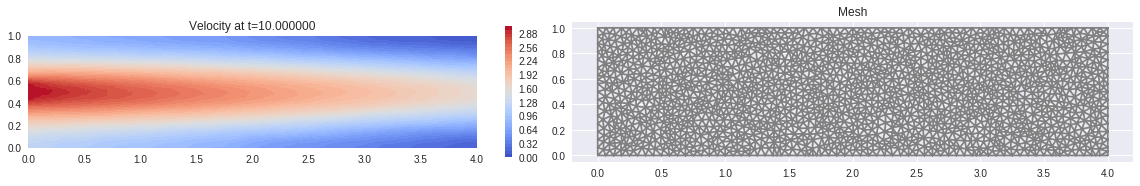

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


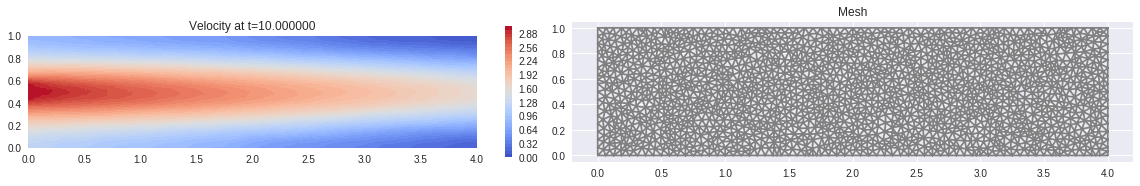

In [13]:
from mshr import *

from dolfin import *

# Define mesh and domain
XMIN = 0.; XMAX = 4.; YMIN = 0.; YMAX = 1.;
R = 0.1
G = [XMIN, XMAX, YMIN, YMAX]; eps=1e-5
circle0 = Circle(Point(0.5,0.5),R)
circle1 = Circle(Point(1.5,0.25),0.2)
circle2 = Circle(Point(1.5,0.75),0.2)

meshdensity = 50
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3]))-circle0, meshdensity)

# FEM functions
#PV = 1
#PQ = 1
#V = VectorFunctionSpace(mesh , "CG", PV); 
#Q = FunctionSpace(mesh , "CG", PQ);
#W = V * Q;
#NC = 3;
#Z = Q;

#for nc in xrange(0, NC-1):
#    Z = Z * Q;


VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

NC = 3;
ZE = QE;

for nc in range(0, NC-1):
   ZE = ZE * QE;

Z = FunctionSpace(mesh, ZE)

    
# h = CellSize(mesh);

h = 2*Circumradius(mesh);

(v, q) = TestFunctions(W);
z = TestFunction(Z);
w = Function(W); 
c = Function(Z); 
(u, p) = (as_vector((w[0], w[1])), w[2]);
u0 = Function(V);
c0 = Function(Z);


nu = 1e-9; # diffusion parameter
gamma = 1e4; # penatly parameter for the Dirichlet BCs 
kappa = 1e-6; # reaction rate

# BC & BOUNDARY MARKERS
uin = Expression(("amplitude*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), amplitude=4., YMAX=YMAX, degree=2) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX , eps=eps, degree=1) # Mark regions for boundary conditions 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN , eps=eps, degree=1)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN , XMAX=XMAX , eps=eps, degree=1)
cm0 = Expression("x[1] > ym0 ? y0 : y1", ym0=0.9, y0=1.,y1=0., degree=1)
cm1 = Expression("x[1] < ym1 ? y0 : y1", ym1=0.1,  y0=1.,y1=0., degree=1)
cm2 = Expression("x[1] > ym1 && x[1] < ym0 ? 1. : 0.0", ym0=0.55, ym1=0.45, degree=1)

cms = [cm0, cm1, cm2]
vals = [1., 1., 3.]
coeffs = [1., 1., 1.]

k = 0.1; # TIMESTEP
d = 0.4*h*sqrt(h) # stabilization parameter
t, T = 0., 10.
stepcounter=0;
w1 = Function(W); 
w2 = Function(Z); 
ctot = Function(Q)

stepcounter = 0; pl = None; ax = None

while t < T:
    (u, p) = (as_vector((w1[0], w1[1])), w1[2]);
    c = Function(Z);
    
    # Solve the Navier-Stokes using midpoint method
    um = (u+u0)/2.;
    wbc_ns = gamma*(om*p*q+im*inner(u-uin,v)+nm*inner(u,v))*ds; # weak boundary cond.
    stab_ns = d*(inner(grad(p)+grad(um)*um,grad(q)+grad(um)*v)+inner(div(um),div(v)))*dx; # Stabilization
    r = (inner((u-u0)/k+grad(p) + grad(um)*um,v) + nu*inner(grad(um),grad(v)) + div(um)*q)*dx + wbc_ns + stab_ns
    solve(r == 0, w1)
    (u, p) = w1.split(True)
    
    # Solve the convection-reaction using implicit Euler method
    stab_cr = d*inner(grad(c)*u, grad(z)*u)*dx + d*inner(grad(c), grad(z))*dx # Stabilization
    cs = c[0]; zs = coeffs[0]*z[0]; bcs = im*cms[0]*inner(c[0] - vals[0], z[0]);
    for nc in range(0, NC-1):
        cs = cs * c[nc+1];
        zs = zs + coeffs[nc+1]*z[nc+1];
        bcs = bcs + im*cms[nc+1]*inner(c[nc+1] - vals[nc+1], z[nc+1])

    wbc_cr  = gamma*bcs*ds # Weak boundary cond. 
    
    r_C = (inner(c - c0, z)/k + inner(dot(grad(c), u), z))*dx + kappa*cs*zs*dx + wbc_cr + stab_cr;     
    solve(r_C == 0, c)

    cs = c[0]; 
    for nc in range(0, NC-1):
        cs = cs + coeffs[nc+1]*c[nc+1];
    Mc = k*om*cs*ds;
    ctot += assemble(Mc) # Compute total concentration flowing out

    cnorm = project(sqrt(inner(c, c)), Q); 

    pl, ax = plot_compact(cnorm, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
        
    # Shift to the next step
    t += k;
    u0=project(u,V)
    c0=project(c,Z)
    stepcounter += 1;

